In [1]:
import numpy as np
import pandas as pd

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score_v2,
                           classification_mean_width_score,
                           coverage_width_based)

from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


c:\Users\fahim\miniconda3\envs\torch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Human Activity Recognition Dataset

In [2]:
# dataset preparation

dataset_id = 1478 # har dataset
dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# handle datatypes
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# display dataset
display(X.head(5))
print("class labels:", label_encoder.classes_)
print("class distribution:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989303,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


class labels: ['1' '2' '3' '4' '5' '6']
class distribution: [1722 1544 1406 1777 1906 1944]


## Model Training and Evaluation

In [3]:
# base model

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf =  clf.fit(X_train, y_train)


##### Mapie

In [4]:
# parameter initialization
alpha = [0.1] # 90% confidence level

coverage: [1.]
mean width: 1.2567961165048545
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       369
           2       0.97      0.98      0.98       270
           3       0.98      0.96      0.97       284
           4       0.95      0.95      0.95       377
           5       0.95      0.95      0.95       354
           6       1.00      1.00      1.00       406

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



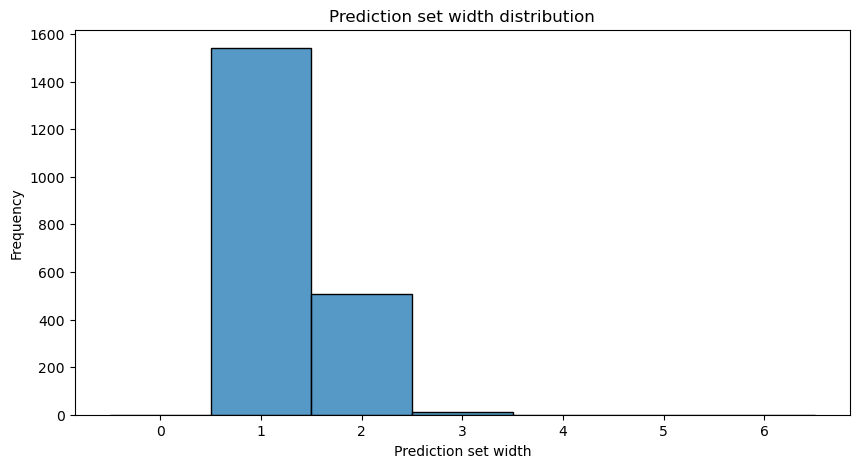

In [9]:
# mapie classifier with raps method
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="raps") 
mapie_score.fit(X_cal, y_cal)

y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)
y_ps_score = np.squeeze(y_ps_score) # remove the extra dimension

# evaluation
print("coverage:", classification_coverage_score_v2(y_test, y_ps_score))
print("mean width:", classification_mean_width_score(y_ps_score))
print(classification_report(y_test, y_pred_score, target_names=label_encoder.classes_))

# plot the prediction distribution
widths = [np.sum(pred) for pred in y_ps_score] # width of prediction sets
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(widths, bins=np.arange(0, 8) - 0.5, edgecolor='black', kde=False)
plt.xlabel("Prediction set width")
plt.ylabel("Frequency")
plt.title("Prediction set width distribution")
plt.show()
